# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090B Introduction to Data Science

## Lab 5:  Feed Forward Neural - Regularization

**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb<br/>
<br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Table of Contents
- Regularization
    - Early Stopping (Keras Callbacks)
    - Norm Penalties (L1 & L2)
    - Dropout
    - Data Augmentation (Gaussian Noise)
- Batchnorm 
- Data Generators (more data augmentation!)
- Activity (Fashion MNIST regularization)

In [99]:
import copy
import operator
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random as rn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import tensorflow as tf

# This will hide oneDNN notifications from Tensorflow
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# You can adjust the notebook width if you like
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
# Recite the sacred reproducibility incantation
os.environ['PYTHONHASHSEED'] = '0'
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
rn.seed(109)

## Overfitting

In the previous lab on optimizers we were running our examples on an oversimplified dataset where all the datapoints are right on top of the true generating function. But the real world is noisy!

In [108]:
df = pd.read_csv('data/lorentz_noise_set2.csv')
df = df.sample(frac=1, random_state=109) # shuffle DataFrame!

scaler = StandardScaler()
df['x_std'] = scaler.fit_transform(df[['x']])
x_train, x_test, y_train, y_test = train_test_split(df.x_std, df.y, train_size=0.7, random_state=109)

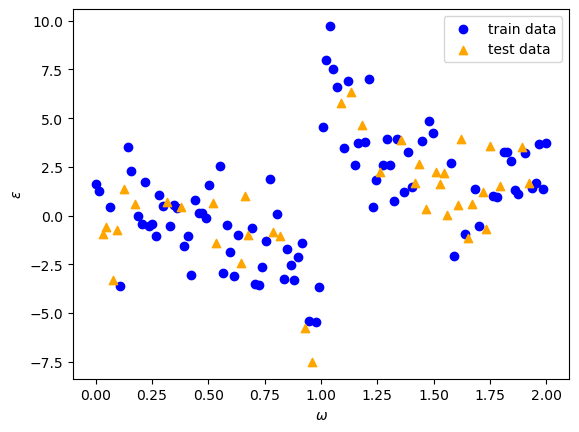

In [109]:
def plot_lorentz(df, test_idx, ax=None):
    if ax is None:
        ax = plt.gca()
    train_mask = np.ones(df.shape[0], dtype=bool)
    train_mask[test_idx] = False
    ax.scatter(df.x[train_mask],df.y[train_mask], c='b', label='train data')
    ax.scatter(df.x[~train_mask],df.y[~train_mask], c='orange', marker='^', label='test data')
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('$\epsilon$')
    ax.legend()

plot_lorentz(df, x_test.index)

How does the best performing model from the previous lab fare on this more realistic dataset?

In [110]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [111]:
# Helper function for plotting training history
def plot_history(model, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label='train')
    ax.plot(model.history.history['val_loss'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE')
    best_loss = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.nanargmin(model.history.history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    ax.legend()
    ax.set_title(title)

CPU times: user 24.1 s, sys: 6.23 s, total: 30.4 s
Wall time: 23.7 s


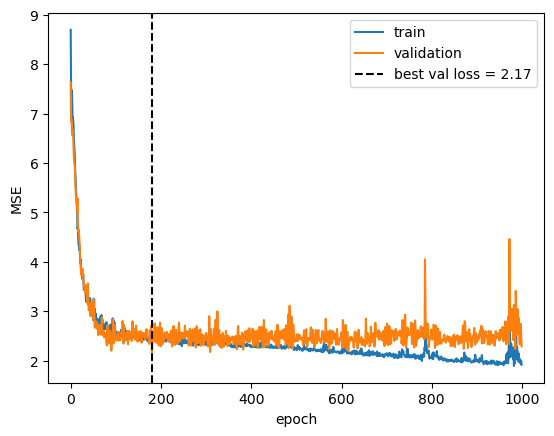

In [112]:
%%time
inputs = Input(shape=(1,))
x = Dense(64, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
NN2 = Model(inputs=inputs, outputs=outputs)
NN2.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')
NN2.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=1000,
        verbose=0)

plot_history(NN2);

There are clear signs of overfitting as the validation error starts to diverge from the train error. Any "improvement" seen with respect to the training data after a certain point no longer generalizes. And after a while, we actually start to see the validation loss increasing.

16/16 [==============================] - 0s 744us/step


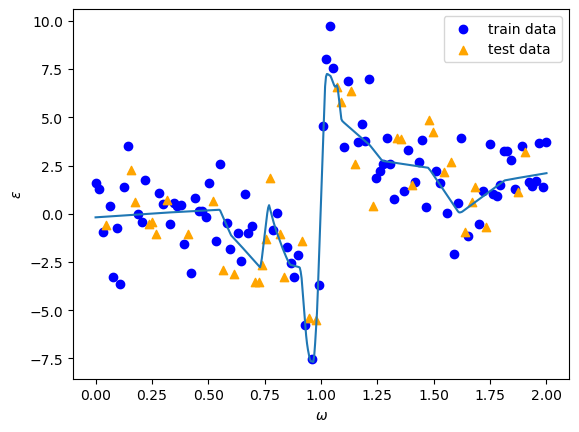

In [125]:
# Plot the overfit predictions
plot_lorentz(df, test_idx=x_test.index)

def plot_predictions(model):
    x_lin = np.linspace(df.x.min(), df.x.max(), (500)).reshape(-1,1)
    y_hat = model.predict(scaler.transform(pd.DataFrame(x_lin, columns=['x'])))
    ax = plt.gca()
    ax.plot(x_lin, y_hat);

plot_predictions(NN2)

And here we can see the model predictions jump around as it tries to fit the sparse and noisy points in the training data.\
Luckily we have several tools at our disposal for addressing overfitting in neural networks.

## Part 1: Regularization

<div class='exercise'><b>Early Stopping (Keras Callbacks)</b></div></br>

Training a NN can take a long time. We should checkpoint our model so we don't lose progress and stop early if we don't see improvement to help save on training time. This motivates [Keras Callbacks](https://keras.io/api/callbacks/).

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [118]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

[`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) allows us to end the training process if we haven't seen an improvment in some loss or metric of our choice (`monitor`) for some number of epochs (`patience`). This even gives us the option of reverting back to the best state of the network (according to the chosen metric) when training ends.

In [119]:
# monitor validation loss and stop training if it does not improve for 75 epochs
# once training stops, restore the weights with the lowest validation loss
es = EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True, verbose=1)

[`ModelCheckpoint`](https://keras.io/api/callbacks/model_checkpoint/) lets us save our models to disk periodically. For example, you might want to update your saved model file each time there is an improvement. Just imagine how sad it would be if your kernel died or there was some other failure thousands of epochs into the training process. Checkpointing can prevent these tragedies, but it does slow down training while saving the weights.

In [120]:
mc = ModelCheckpoint('data/models', monitor='val_loss', save_best_only=True, save_weights_only=False)

We can also execute arbitrary functions at different the start/end of a batch/epoch using the [`LambdaCallback`](https://keras.io/api/callbacks/lambda_callback/).

In [121]:
# Use a lambda callback to print the epoch number every 50 epochs.
lcall = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f'epoch {epoch}') if epoch % 50 == 0 else None)

Any callbacks we wish to use during training are passed as a list to the `fit` function's `callbacks` argument.

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
Restoring model weights from the end of the best epoch: 128.
Epoch 203: early stopping
CPU times: user 5.42 s, sys: 1.4 s, total: 6.82 s
Wall time: 5.42 s


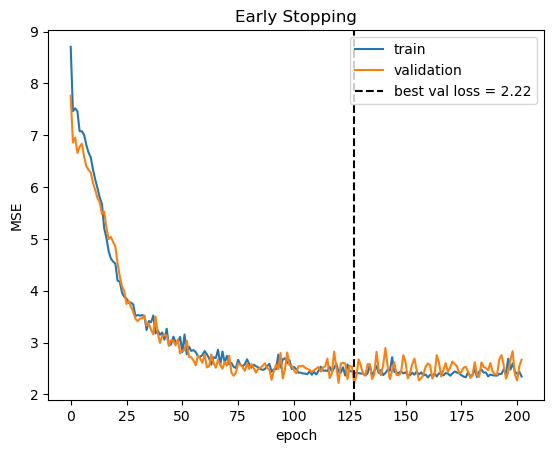

In [122]:
%%time
inputs = Input(shape=(1,))
x = Dense(64, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
NN_es = Model(inputs=inputs, outputs=outputs)
NN_es.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_es.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=1000,
        callbacks=[es, lcall],
        verbose=0)
plot_history(NN_es, title="Early Stopping")

16/16 [==============================] - 0s 761us/step


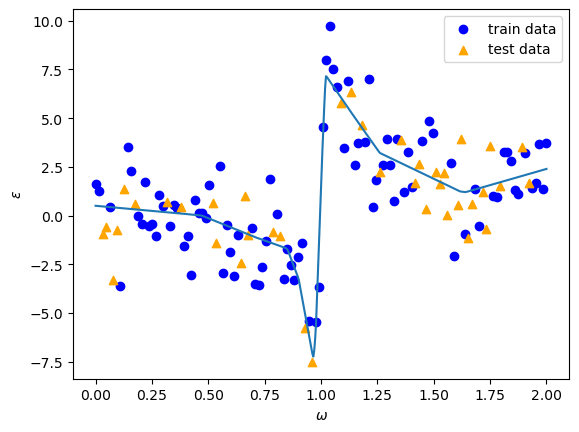

In [126]:
plot_lorentz(df, test_idx=x_test.index)
plot_predictions(NN_es)

### Weight Decay

In [127]:
from tensorflow.keras.regularizers import L1, L2

We can also add a penalty term to our loss function that penalizes the model based on the magnitutes of its weights. This forces the network to find a balance between model complexity and goodness-of-fit to the training data, reducing the tendency to overfit.

**$L_2$ Regularization**

Penalty based on the square of network weights.

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
Restoring model weights from the end of the best epoch: 282.
Epoch 357: early stopping
CPU times: user 9.45 s, sys: 2.54 s, total: 12 s
Wall time: 9.32 s


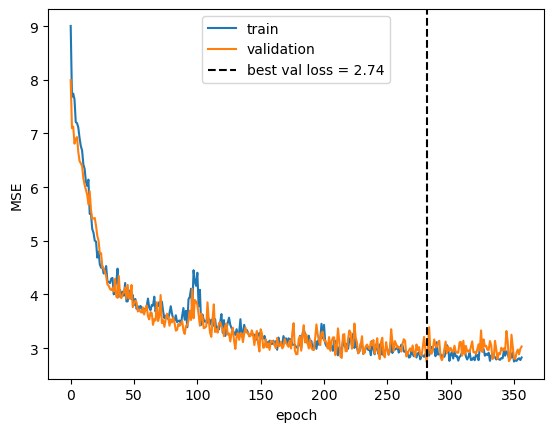

In [128]:
%%time

# Regularize the kernel and bias using L2 regularization coefficient l2=0.005
# your code here
kernel_regularizer = L2(l2=0.005)
 # your code here
bias_regularizer = L2(l2=0.005)

inputs = Input(shape=(1,))
x = Dense(64, activation='relu',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(inputs)
x = Dense(128, activation='relu',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(x)
outputs = Dense(1, activation='linear')(x)
NN1 = Model(inputs=inputs, outputs=outputs)
NN1.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999), loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
        callbacks=[es, lcall],
        verbose=0)
plot_history(NN1)

**$L_1$ Regularization**

Penalty based on the absolute value of model weights. Like LASSO in linear regression, this tends to push some weights to zero, resulting in "sparsity" (i.e., some nodes are "off" in the network).

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
Restoring model weights from the end of the best epoch: 252.
Epoch 327: early stopping
CPU times: user 8.64 s, sys: 2.34 s, total: 11 s
Wall time: 8.51 s


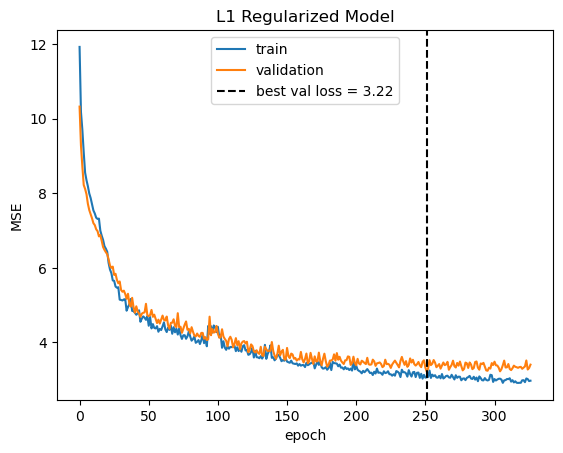

In [129]:
%%time

# Regularize the kernel and bias using L1 regularization coefficient l1=0.005
# your code here 
kernel_regularizer = L1(l1=0.005)
# your code here 
bias_regularizer = L1(l1=0.005) 

inputs = Input(shape=(1,))
x = Dense(64, activation='relu',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(inputs)
x = Dense(128, activation='relu',
          kernel_regularizer=kernel_regularizer,
          bias_regularizer=bias_regularizer)(x)
outputs = Dense(1, activation='linear')(x)
NN_L1 = Model(inputs=inputs, outputs=outputs)
NN_L1.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_L1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
        callbacks=[es, lcall],
        verbose=0)
plot_history(NN_L1, title='L1 Regularized Model')

### [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

In [130]:
from tensorflow.keras.layers import Dropout

[tensorflow.keras.layers.Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

At each batch during training time, the Dropout layer randomly sets input units to 0 with probability `rate`. For example, `rate=0.25` would cause any input to the layer to have a 25% chance of being set to zero. 

Note that the Dropout layer only applies during training and no values are dropped during inference. 

Even if individual weight magnitudes are constrained with methods like weight decay above, many weights can "conspire" within a network to collectively have a large effect. Dropout helps prevent this because no weight can "rely" on any other for its affect as it may be turned off. 

You can also think of dropout as turning your network into a aggregated ensemble of smaller neural networks! 

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
Restoring model weights from the end of the best epoch: 150.
Epoch 225: early stopping
CPU times: user 5.97 s, sys: 1.56 s, total: 7.53 s
Wall time: 6.01 s


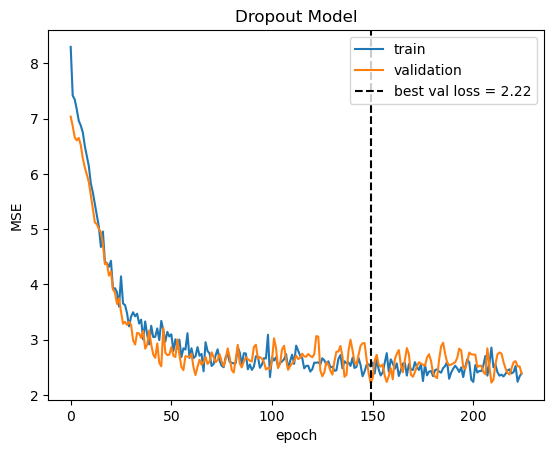

In [131]:
%%time
dropout_rate = 0.05
inputs = Input(shape=(1,))
x = Dense(64, activation='relu')(inputs)
x = Dropout(rate=dropout_rate)(x)
x = Dense(128, activation='relu')(x)

# Pass the data through a dropout layer with the rate set to dropout_rate
# your code here
x = Dropout(rate=dropout_rate)(x)

outputs = Dense(1, activation='linear')(x)
NN_do = Model(inputs=inputs, outputs=outputs)
NN_do.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_do.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
        callbacks=[es, lcall],
        verbose=0)
plot_history(NN_do, title='Dropout Model')

## Batch Normalization (Batchnorm) 

When we have inputs on different scales, we are advised to standardize them to put everything on the same scale.\
But now consider that from the perspective of the 2nd layer in your network, the outputs of the first layer are its input features. Should these be standardized for the same reasons we standardize the input to the first layer?

Batch Normalization extends the idea of feature rescaling to (potentially) all the layers in your network.

The "batch" in the name refers to the fact the the mean and standard deviation used for the standardization are "noisy" approximations calculated from the current mini-batch. This "noisiness" can have a *slight* regularization effect.

More importantly, it helps keep the distribution of input values going into a given layer from shifting around. Your layer is trying to learn weights to map its input to the appropriate input, but this is made very difficult if the input values look wildly different after weights in the previous layers are also updated; it's like trying to hit a moving target.

Batchnorm is normally placed *between* the affine transformation of a neuron and its activation function.
A batchnorm layer has two trainable parameters which allow the network to learn what the ideal mean and standard deviation are for the data to possess before being passed through the activation function. Consider why this might be important for certain activation functions like relu or sigmoid.

If we want to put a batchnorm layer before our activation functions then we can forego specifying an activation in the `Dense` layer and instead use an `Activation` layer!

In [132]:
from tensorflow.keras.layers import Activation, BatchNormalization

Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_330 (Dense)           (None, 64)                128       
                                                                 
 batch_normalization_146 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 activation_146 (Activation  (None, 64)                0         
 )                                                               
                                                                 
 dropout_150 (Dropout)       (None, 64)                0         
                                                                 
 dense_331 (Dense)           (None, 16)                104

None

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350
epoch 400
epoch 450
epoch 500
epoch 550
epoch 600
epoch 650
epoch 700
epoch 750
epoch 800
epoch 850
epoch 900
epoch 950
Restoring model weights from the end of the best epoch: 798.
Epoch 998: early stopping
CPU times: user 39.3 s, sys: 6.34 s, total: 45.7 s
Wall time: 37.8 s


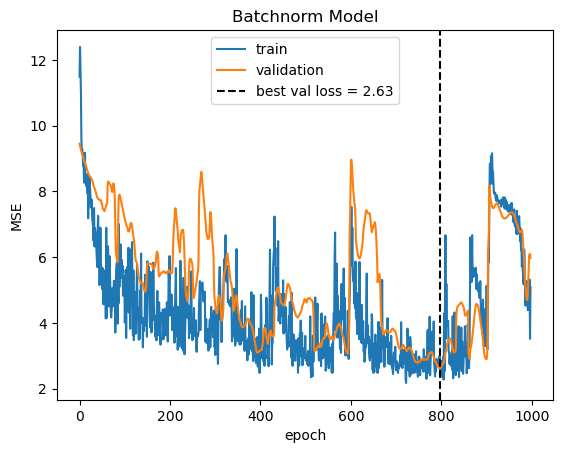

In [152]:
%%time
dropout_rate = 0.05
activation='relu'
inputs = Input(shape=(1,))
x = Dense(64, activation=None)(inputs)

x = BatchNormalization()(x)
x = Activation(activation)(x)
x = Dropout(dropout_rate, seed=109)(x)
for i, n_nodes in enumerate([16]*12):
    x = Dense(n_nodes, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate, seed=209+i)(x)
outputs = Dense(1, activation='linear')(x)
NN_bn = Model(inputs=inputs, outputs=outputs)
display(NN_bn.summary())
NN_bn.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_bn.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=128,
        epochs=3000,
        callbacks=[EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True, verbose=1),
                   lcall],
        verbose=0)
plot_history(NN_bn, title='Batchnorm Model')

### Data Augmentation

In [153]:
from tensorflow.keras.layers import GaussianNoise

The easiest way to fix overfitting is to use more data. This isn't always an option, but we can often "fake it" with some success. The idea behind **data augmentation** is to produce variations of your existing data that are still close enough to real examples. In this way the model becomes less sensitive to any of the idiosyncratic features of your particular training examples and instead will learn what is essential and common across all your generated data.

Perhaps the easiest form of data augmentation is simply adding a bit of gaussian noise to your data points.\
This is made very easy with Keras's [`GaussianNoise`](https://keras.io/api/layers/regularization_layers/gaussian_noise/) layer. Just specify a stddev for the noise distribution. And keep in mind that it can take a random seed!

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
Restoring model weights from the end of the best epoch: 197.
Epoch 272: early stopping
CPU times: user 7.13 s, sys: 1.88 s, total: 9.01 s
Wall time: 7.06 s


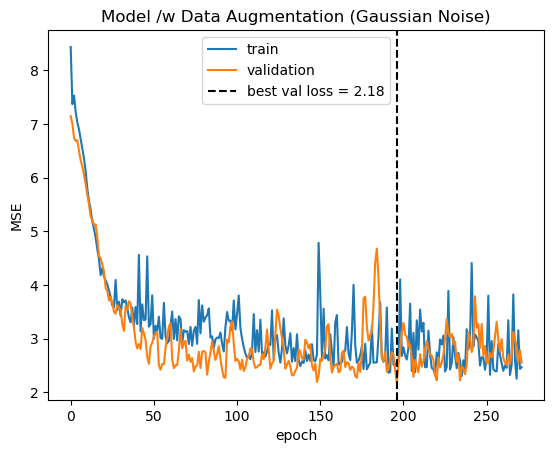

In [155]:
%%time
noise_stddev = 0.02
inputs = Input(shape=(1,))

# Add gaussian noise to your input data here, with random seed 109
# your code here
x = GaussianNoise(noise_stddev)(inputs)

x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
NN_da = Model(inputs=inputs, outputs=outputs)
NN_da.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN_da.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
        callbacks=[es, lcall],
        verbose=0)
plot_history(NN_da, title='Model /w Data Augmentation (Gaussian Noise)')

## Part 2 - Classification with Neural Networks

In this 2nd half of the lab we will be working with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).
<img src="https://4.bp.blogspot.com/-OQZGt_5WqDo/Wa_Dfa4U15I/AAAAAAAAAUI/veRmAmUUKFA19dVw6XCOV2YLO6n-y_omwCLcBGAs/s400/out.jpg" width="400px" />

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

We will be using a very small fraction of the dataset. The goal is to first overfit a NN to this classification task and then use the tools explored in the 1st half of the notebook to regularize and improve the model through hyperparameter tweaking.

But first, we will explore a new option for **image data augmentation** through the use of Keras's `ImageDataGenerator` ojects which may be useful to us.

## DataGenerators in Keras

This section shows how to build data generators from a collection of image files to be used for training a Keras model. The process of creating the file structure required by data generators is normally quite tedious. The code below can be adapted and reused for your own projects to save you a lot of time!

[(keras ImageGenerator documentation)](https://keras.io/preprocessing/image/)

Fashion-MNIST and other pre-loaded dataset are formatted in a way that is almost ready for feeding into a model. But what about your average image files? They should be appropriately preprocessed into floating-point tensors before being fed into the network.

Imagine you have a bunch of dog and cat images you want to prepare for a Keras model using a `ImageDataGenerator`.</br>
We need to create:
1. train, validation, and test directories, each containing a subset of the images.
2. separate cat and dog directories _within_ train, validation, and test.

Number 2 is necessary because the Keras ImageDataGenerator infers the class label from the subdirectory the image resides in.

The directory structure should then look like this:

```
 dogs_vs_cats
 ├── test
 │   ├── cats
 │   └── dogs
 ├── train
 |   ├── cats
 |   └── dogs
 └── validation
     ├── cats
     └── dogs
```

This is what we will do for the `Fashion-MNIST` data. It would be a lot of work to do it manually, especially with 10 classes! But it isn't to difficult to take care of all of this programatically.

**A Note About JupyterHub:**

One weakness of the JupyterHub server is slow disk read & write speeds. So if you decide to use the Datagenerators (which requires that files be read from disk each batch) then you may find it runs just as fast (if not faster) on your local machine. We'll see an alternative to Datagenerators later in the course.

In [156]:
# Load entire Fashion-MNIST dataset from Tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

These are the 10 class labels and the integer they map to in `y_train` and `y_test`.

In [157]:
# Fashion-MNIST class labels
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label2idx = {label: idx for idx, label in enumerate(labels)}
label2idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Here's some examples from the dataset.

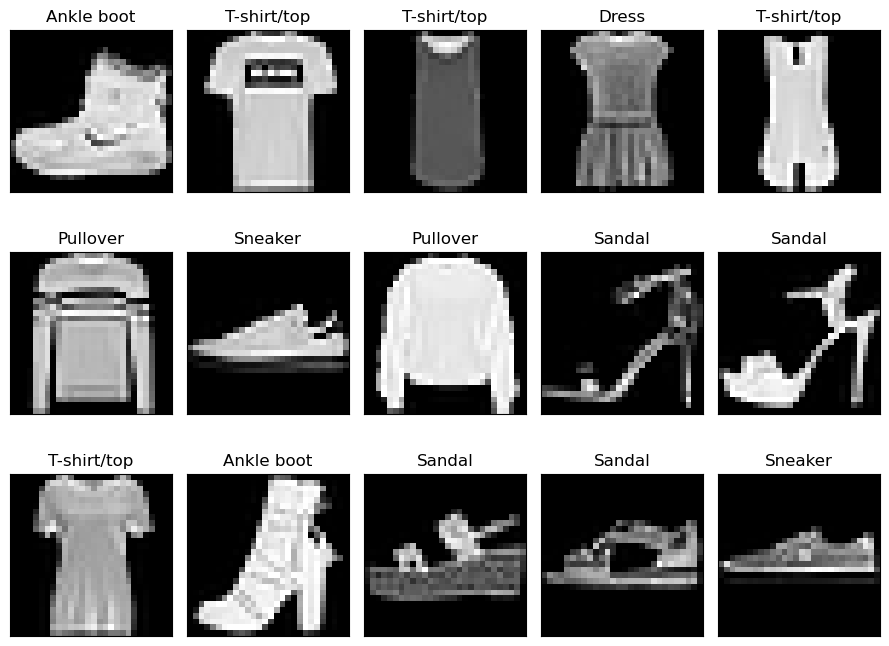

In [158]:
# Fashion-MNIST examples
fig, axs = plt.subplots(3,5, figsize=(9,7))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_train[i], cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(labels[y_train[i]])
plt.tight_layout()

In [159]:
# Dataset size
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Because our goal is to first overfit (and have a model we can train multiple times as we experiment during the lab!) we will discard most of the training data. We'll do stratified splits to avoid biasing our sample. The classes are equally represented in the original dataset.

In [160]:
# Throw away most of the training data to make things more difficult
# We'll also toss most of the test data (writing it all to disk is slow on JupyterHub anyway!)
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size=0.10, stratify=y_test)
x_train, _, y_train, _ = train_test_split(x_train, y_train, train_size=0.02, stratify=y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [161]:
# Sample size
x_train.shape, x_val.shape, x_test.shape

((960, 28, 28), (240, 28, 28), (1000, 28, 28))

The `PIL` module (Python Image Library) is useful for taking the numpy arrays that currently represent the images and writing them to disk as jpeg files. 

In [162]:
from PIL import Image

In [163]:
DATA_DIR = 'data/fashionMNIST' # create path name for data

In [164]:
data = {'train': (x_train, y_train),
        'validation': (x_val, y_val),
        'test': (x_test, y_test)}

In [165]:
%%time
# Construct directory structure and write image files to disk
if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)

    for split, (x, y) in data.items():
        for label in labels:
            label_s = label.replace('/','_')
            new_dir = os.path.join(DATA_DIR, split, label_s)
            os.makedirs(new_dir, exist_ok=True)
            target = label2idx[label]
            cur_images = x[y==target]
            for i in range(cur_images.shape[0]):
                im = Image.fromarray(cur_images[i]).convert("L")
                filename = f"{label_s}_{split}_{i:04d}"
                im.save(f"{DATA_DIR}/{split}/{label_s}/{filename}.jpeg")

CPU times: user 251 ms, sys: 364 ms, total: 615 ms
Wall time: 25.3 s


In [166]:
# number of images in each subdir
for dir_name in data.keys():
    print(dir_name)
    for label in labels:
        label_dir = label.replace('/','_')
        print('\t'+label_dir, len(os.listdir(DATA_DIR + '/' + dir_name + '/' + label_dir)))

train
	T-shirt_top 96
	Trouser 96
	Pullover 96
	Dress 96
	Coat 96
	Sandal 96
	Shirt 96
	Sneaker 96
	Bag 96
	Ankle boot 96
validation
	T-shirt_top 24
	Trouser 24
	Pullover 24
	Dress 24
	Coat 24
	Sandal 24
	Shirt 24
	Sneaker 24
	Bag 24
	Ankle boot 24
test
	T-shirt_top 100
	Trouser 100
	Pullover 100
	Dress 100
	Coat 100
	Sandal 100
	Shirt 100
	Sneaker 100
	Bag 100
	Ankle boot 100


<div class='exercise'><b>Create the Generators</b></div></br>

Now that we have the data in the correct directory structure we can create the data generators.</br>
Note that we will have _multiple_ generators, one for each split directory.</br>
First we create a a main data generator object, `datagen`. This can be a given a wide range of arguments which can be used to preprocess the images it generates.</br>
For right now we will only use the `rescale` argument to normalize all pixel values to between 0 and 1. (Remember that image data is stored with pixels shaded from 0 to 255.)

In [167]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

The `ImageDataGenerator` can automate the scaling of normalizing the image pixel values to [0,1]. This is just a first glimpse of how these objects can help with a preprocessing and training pipeline!

In [168]:
datagen = ImageDataGenerator(rescale=1./255)

Now we use `datagen`'s `flow_from_directory` method to create the 3 generators: `traingen`, `valgen`, and `testgen`.</br>
The need to be given the `directory` which they will use as their image source, a `target_size` to resize all images to (e.g., (14,14)), a `batch_size`, and `class_mode` to instruct the generator on how to interpret the label folders. We should probably also set `shuffle = False` in the test generator so it produces the same images in the same order everytime it is used. We also set `color_mode='grayscale'`. Otherwise, the default is to output color images which would be of shape `(28, 28, 3)` because they have 3 color channels (more on that next lab!).

In [169]:
batch_size = 32
target_size = (28, 28) # generator can resize all images if we want
# this is the augmentation configuration we will use for training

traingen = datagen.flow_from_directory(
                                DATA_DIR+'/train',  # this is the target directory
                                target_size=target_size,  # all images will be resized to 150x150
                                batch_size=batch_size,
                                class_mode='categorical',  # since we use categorical_crossentropy loss, we need binary labels
                                 color_mode='grayscale')
valgen = datagen.flow_from_directory(
                                DATA_DIR+'/validation',
                                target_size=target_size, 
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='grayscale') 

testgen = datagen.flow_from_directory(
                        DATA_DIR+'/test',  
                        target_size=target_size, 
                        batch_size=batch_size,
                        shuffle = False,
                        class_mode='categorical',
                        color_mode='grayscale') 

Found 960 images belonging to 10 classes.
Found 240 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


Let’s look at the output of one of these generators to see how `target_size` and `batch_size` affects the output. Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point if using a `for` loop. Better still, you can use the built-in `next` function to return a single element from the generator.

In [170]:
data_batch, labels_batch = next(traingen)
print('data batch shape:', data_batch.shape)
print('labels batch shape:', labels_batch.shape)

data batch shape: (32, 28, 28, 1)
labels batch shape: (32, 10)


<div class='exercise'><b>Construct a Classifier NN</b></div></br>

Let's built our first attempt at a clothing classifier and try to overfit.

Note that Keras has a `Flatten` layer! We can use this to automatically turm input images into 1D arrays.\
(We'll see how to handle 2D input in future lectures and labs) 

In [171]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Activation, Input, BatchNormalization, Dense, Dropout, Flatten, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD

In [172]:
# Overfit Fashion-MNIST Classifier
input_dim = data_batch.shape[1:]
n_classes = labels_batch.shape[-1]
inputs = Input(shape=(input_dim))

# Flatten the inputs here to turn them into 1D arrays.
flat = Flatten()(inputs) 

x = Dense(256, activation=None, kernel_initializer='he_uniform')(flat)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(64, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(32, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(n_classes, activation=None, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
outputs = Activation('softmax')(x)
NN = Model(inputs, outputs)
NN.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
NN.summary()

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_350 (Dense)           (None, 256)               200960    
                                                                 
 batch_normalization_159 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 activation_159 (Activation  (None, 256)               0         
 )                                                               
                                                                 
 dense_351 (Dense)           (None, 128)               328

<div class='exercise'><b>Keras Callbacks</b></div></br>

We'll use early stopping with short patience so we can call it quits early when it looks like we are overfitting so we can save time.

In [173]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [es]

<div class='exercise'><b>Fit Model with Generator</b></div></br>

Let’s fit the model to the data using the generator. You can use `fit` as before but this time you will pass it generators rather than dataframes or numpy arrays.  

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps - the fitting process will go to the next epoch. 

When using `fit`, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation

In [174]:
%%time
history = NN.fit(
        traingen,
        steps_per_epoch=traingen.samples//traingen.batch_size,
        epochs=30,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        callbacks=callbacks,
        workers=-1,
        use_multiprocessing=True,
        verbose=1)

Epoch 1/30
30/30 [==============================] - 5s 81ms/step - loss: 1.5113 - accuracy: 0.5531 - val_loss: 2.0353 - val_accuracy: 0.2723
Epoch 2/30
30/30 [==============================] - 2s 58ms/step - loss: 1.0159 - accuracy: 0.7510 - val_loss: 1.5905 - val_accuracy: 0.6071
Epoch 3/30
30/30 [==============================] - 2s 58ms/step - loss: 0.8592 - accuracy: 0.8052 - val_loss: 1.3140 - val_accuracy: 0.7366
Epoch 4/30
30/30 [==============================] - 2s 57ms/step - loss: 0.7311 - accuracy: 0.8438 - val_loss: 1.2877 - val_accuracy: 0.6920
Epoch 5/30
30/30 [==============================] - 2s 57ms/step - loss: 0.7109 - accuracy: 0.8562 - val_loss: 1.1033 - val_accuracy: 0.7455
Epoch 6/30
30/30 [==============================] - 2s 55ms/step - loss: 0.6194 - accuracy: 0.8906 - val_loss: 0.9657 - val_accuracy: 0.7589
Epoch 7/30
30/30 [==============================] - 2s 58ms/step - loss: 0.5682 - accuracy: 0.8958 - val_loss: 0.9284 - val_accuracy: 0.7679
Epoch 8/30
30

<div class='exercise'><b>Evaluate the Model</b></div></br>

In [175]:
NN.evaluate(traingen)

30/30 [==============================] - 1s 44ms/step - loss: 0.1689 - accuracy: 0.9844


[0.16894488036632538, 0.984375]

In [176]:
NN.evaluate(valgen)

8/8 [==============================] - 0s 43ms/step - loss: 0.7065 - accuracy: 0.7917


[0.7065125703811646, 0.7916666865348816]

In [177]:
NN.evaluate(testgen)

32/32 [==============================] - 2s 60ms/step - loss: 0.7751 - accuracy: 0.7740


[0.775078535079956, 0.7739999890327454]

Let’s plot the loss and accuracy of the model over the training and validation data during training:

<div class='exercise'><b>Plot the Training History</b></div></br>

Final Val Acc: 0.71


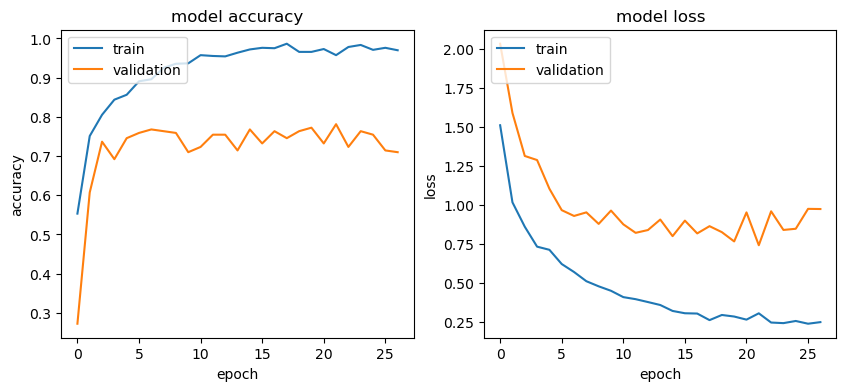

In [178]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
print(f"Final Val Acc: {history.history['val_accuracy'][-1]:.2f}")
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

## Part 2: Now with Data Augmentation

We saw in the lecture on regularization that we can slightly alter our training data to simulate a larger dataset. This means our model is less likely to overfit as it would have to "memorize" more data.

Take a look again at the [ImageDataGenerator Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to see what choices we have for changing our data. Are all changes appropriate here?</br>
Create a new data generator `datagen_aug` that preprocesses images with your chosen changes. Then we only need to make a new `traingen_aug` using `flow_from_directory`.

The `preprocessing_function` argument can be passed an arbitrary function to act on images pulled from the generator. Here we provide an example of a function to add Gaussian noise.

<div class='exercise'><b>Create Augmenting Generator</b></div></br>

In [179]:
# your code here
def add_noise(img):
    VARIABILITY = 100 # customize this
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

datagen_aug = ImageDataGenerator(
      rescale=1./255,
      ## customize these and other parameters
      # rotation_range=0,
      # width_shift_range=0,
      # height_shift_range=0,
      # shear_range=0,
      zoom_range=0.05,
      preprocessing_function=add_noise,
      horizontal_flip=True,
      fill_mode='nearest',
)

# We don't want to augment the validation (or test) data
traingen_aug = datagen_aug.flow_from_directory(
    DATA_DIR+'/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 960 images belonging to 10 classes.


These are just a few of the options available (for more, see the Keras documentation). 
Let’s quickly go over this code:

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half the images horizontally—relevant when there are no assumptions of - horizontal asymmetry (for example, real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift. 

Let’s look at some augmented images generated from a single source image.

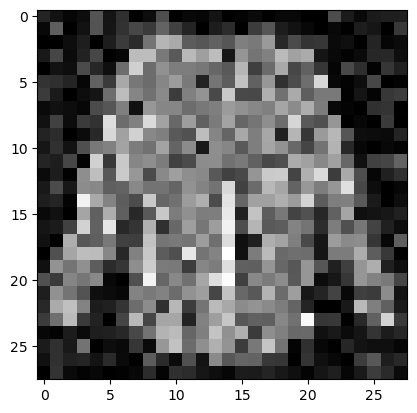

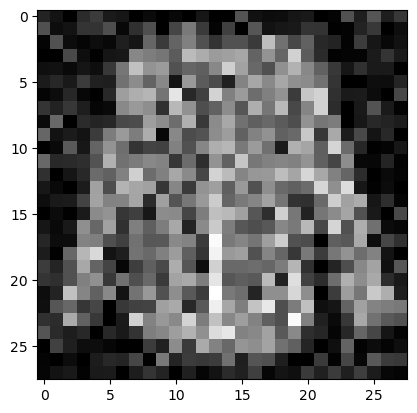

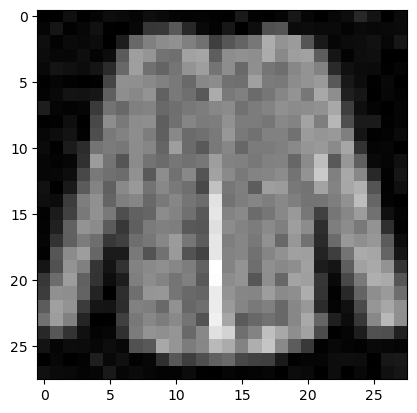

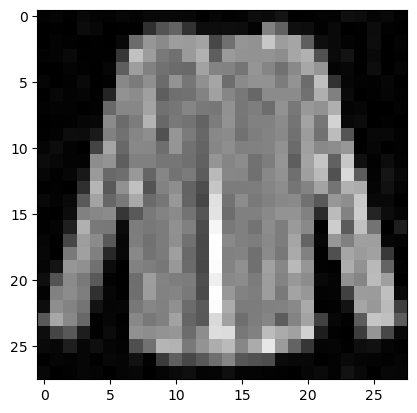

In [180]:
# Examples of augmented images
from tensorflow.keras.preprocessing import image
train_gb_dir = os.path.join(DATA_DIR, 'train', 'Shirt')
fnames = [os.path.join(train_gb_dir, fname) for fname in os.listdir(train_gb_dir)]
img_path = fnames[3] # Chooses one image to augment
img = image.load_img(img_path, target_size=target_size)
# Reads the image and resizes it
x = image.img_to_array(img) # Converts it to a Numpy array
x = x.reshape((1,) + x.shape) # Reshapes it 
i = 0
for batch in datagen_aug.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]).convert('L'), cmap='gray')
    i += 1
    if i % 4 == 0:
        break

plt.show()

Here you can generate a random augmented image.

(28, 28, 1)


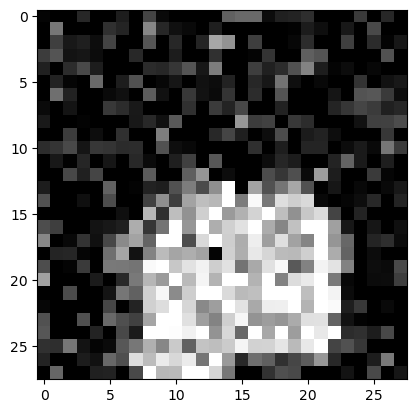

In [181]:
# Sample from augmented data generator
example = next(traingen_aug)[0][0]
print(example.shape)
plt.imshow(example, cmap='gray');

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are obviously very related, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting and improve the model, use all the tools at your disposal: activation functions, initializers, optimizers, regularization techniques, callbacks, and batchnorm!

<div class='exercise'><b>2nd FFN Model</b></div></br>
To see the effect of your choices, you should make several attempts in which you do not change the overall model architecture (i.e., number of layers and nodes).

In [182]:
# your code here
data_batch, labels_batch = next(traingen_aug)
print('data batch shape:', data_batch.shape)
print('labels batch shape:', labels_batch.shape)

input_dim = data_batch.shape[1:]
n_classes = labels_batch.shape[-1]

inputs = Input(shape=(input_dim))
flat = Flatten()(inputs)
# x = ...
# ...
# outputs = ...
# ONE POSSIBLE ARCHITECTURE
x = Dense(512, activation=None)(flat)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(256, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(64, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(32, activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(n_classes, activation=None)(x)
outputs = Activation('softmax')(x)

NN_aug = Model(inputs, outputs)
NN_aug.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
NN_aug.summary()

data batch shape: (32, 28, 28, 1)
labels batch shape: (32, 10)
Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_355 (Dense)           (None, 512)               401920    
                                                                 
 batch_normalization_164 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 activation_164 (Activation  (None, 512)               0         
 )                                                               
                                                             

In [183]:
%%time
# your code here
history_aug = NN_aug.fit(
        traingen_aug,
        steps_per_epoch=traingen_aug.samples//traingen_aug.batch_size,
        epochs=100,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        callbacks=EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        verbose=1)

# save model if needed
NN_aug.save('data/gen_model_aug.keras')

Epoch 1/100
30/30 [==============================] - 4s 66ms/step - loss: 1.6923 - accuracy: 0.4333 - val_loss: 1.8794 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 1.1547 - accuracy: 0.6531 - val_loss: 1.5365 - val_accuracy: 0.6473
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.9619 - accuracy: 0.7302 - val_loss: 1.2719 - val_accuracy: 0.7188
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.8211 - accuracy: 0.7479 - val_loss: 1.0487 - val_accuracy: 0.6875
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7828 - accuracy: 0.7604 - val_loss: 0.8597 - val_accuracy: 0.7054
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.7336 - accuracy: 0.7542 - val_loss: 0.8529 - val_accuracy: 0.6920
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6614 - accuracy: 0.7844 - val_loss: 0.7843 - val_accuracy: 0.7232
Epoch 

Final Val Acc: 0.76


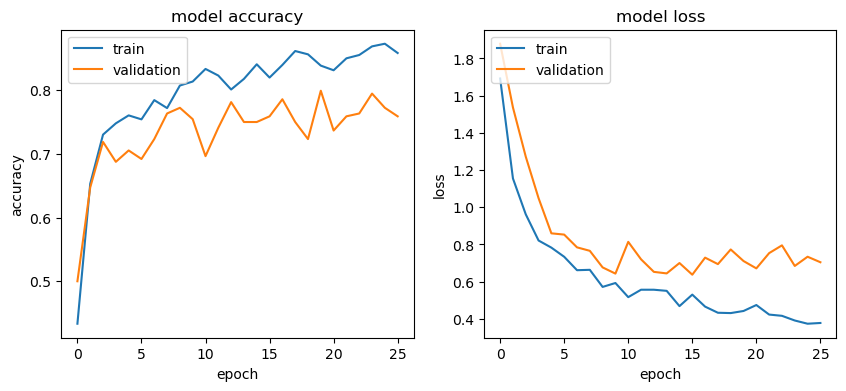

In [185]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
print(f"Final Val Acc: {history_aug.history['val_accuracy'][-1]:.2f}")
axs[0].plot(history_aug.history['accuracy'])
axs[0].plot(history_aug.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history_aug.history['loss'])
axs[1].plot(history_aug.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

In [186]:
NN_aug.evaluate(traingen)

30/30 [==============================] - 1s 42ms/step - loss: 0.3468 - accuracy: 0.8604


[0.34677696228027344, 0.8604166507720947]

In [187]:
NN_aug.evaluate(valgen)

8/8 [==============================] - 0s 40ms/step - loss: 0.6889 - accuracy: 0.7542


[0.6889352798461914, 0.7541666626930237]

In [188]:
NN_aug.evaluate(testgen)

32/32 [==============================] - 1s 41ms/step - loss: 0.7604 - accuracy: 0.7430


[0.760352611541748, 0.7429999709129333]

How high are you able to get the validation accuracy? (Can you beat 83%?) Does it translate well to test accuracy after all your optimization and tuning?